# Conspiracy Analysis

## Data Exploration

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import spacy
import re
from collections import Counter
from typing import List, Dict, Tuple
from wordcloud import WordCloud

In [ ]:

loco = pd.read_json('./data/LOCO.json')
loco = loco[loco['subcorpus'] == 'conspiracy']
loco = loco[['website', 'seeds', 'title', 'txt', 'FB_shares', 'FB_comments', 'FB_reactions']]
loco

In [ ]:
loco.to_csv('./data/conspiracy.csv')

### Keyword Analysis

In [ ]:
websites = loco['website'].value_counts()
websites

In [ ]:
keywords = loco['seeds'].value_counts()
keywords

In [ ]:
compound_keywords = [el for el in keywords.index if (';' in el)]
compound_keywords

In [ ]:
multiple_compounds = loco[loco['seeds'].isin(compound_keywords)]['seeds'].value_counts()
multiple_compounds = multiple_compounds[multiple_compounds > 1]
multiple_compounds[0:20].plot(kind='bar', title="Top 20 Keyword Combinations")

In [ ]:
for key in compound_keywords:
    count = keywords[key]
    independent_keywords = [s.strip() for s in key.split(';')]
    keywords[independent_keywords] += count
    keywords.drop(key, inplace=True)

In [ ]:
keywords.sort_values(inplace=True, ascending=False)
keywords[0:20].plot(kind='bar', title="Top 20 Conspiracy Keywords")

In [ ]:
seeds = [el.replace('.', ' ') for el in loco['seeds'].value_counts().index if ';' not in el]
seeds.sort()
seeds

### Title Analysis

In [ ]:
def vectorized_clean(text_series: pd.Series) -> List[str]:
    non_letter_to_space = re.compile(r'[\-–—]')
    non_letter_to_empty = re.compile(r'([^a-z ])')
    multi_space = re.compile(r'[ ]{2,}')
    return text_series.str.lower().str.replace(non_letter_to_space, ' ').str.replace(non_letter_to_empty, '').str.replace(multi_space, ' ').to_list()

def spacy_clean(text_list: List[str], nlp: spacy.lang) -> List[str]:
    return [[token.lemma_ for token in title if ((not token.is_stop) and (len(token.text) > 1))] for title in nlp.pipe(titles)]

def count_words(text_list: List[str]) -> Dict[str, int]:
    counts = Counter()
    for el in text_list:
        counts += Counter(el)
    return counts

def give_sorted_counts(counter: Dict[str, int], reverse: bool =True) -> List[Tuple[str, int]]:
    return sorted(counter.items(), key=lambda x: x[1], reverse=reverse)

def make_word_cloud(counter: Dict[str, int]) -> None:
    wc = WordCloud(width=1280, height=720, scale=1.25)
    wc.generate_from_frequencies(counter)

    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
nlp = spacy.load("en_core_web_md")

titles = vectorized_clean(loco['title'])
clean_titles = spacy_clean(titles, nlp)
title_counts = count_words(clean_titles)
give_sorted_counts(title_counts)

In [ ]:
make_word_cloud(title_counts)

### Body Analysis

In [ ]:
bodies = vectorized_clean(loco['txt'])
clean_bodies = spacy_clean(bodies, nlp)
body_counts = count_words(clean_bodies)
give_sorted_counts(body_counts)

In [ ]:
make_word_cloud(body_counts)

## Modelling

In [ ]:
texts = (loco['title'] + ': ' + loco['txt']).tolist()

### NER 

In [ ]:
from itertools import combinations

apostrophe_re = re.compile(r"[’']s")

def should_include_ne(name: str, ne_type: str) -> bool:
    irrelevant_nes = {'TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'ORDINAL', 'CARDINAL', 'DATE', 'GPE', 'NORP'}
    is_911 = (name == '9/11') and ne_type in irrelevant_nes
    return is_911 or (ne_type not in irrelevant_nes)

def clean_entity_name(ne: str) -> str:
    return re.sub(apostrophe_re, '', ne)

def filter_entities(ne_list: List[Tuple[str, str]]) -> List[Tuple[str, str]]:
    return list(set([(clean_entity_name(name), ent_type) for name, ent_type in ne_list if should_include_ne(name, ent_type)]))

def create_pairings(texts: List[str]) -> Dict[Tuple[Tuple[str]], int]:
    title_named_entities = [[(token.text, token.label_) for token in title.ents] for title in nlp.pipe(texts)]
    title_named_entities = [filter_entities(el) for el in title_named_entities if len(el) > 0]
    ne_pairs = Counter()

    for article in title_named_entities:
        ne_pairs += Counter(combinations(article, 2))

    return ne_pairs

spacy.prefer_gpu()
nlp = spacy.load("en_core_web_trf")


In [ ]:
ne_pairs = create_pairings(texts[:200])
ne_pairs

In [ ]:
ne_df = []

for nes, count in ne_pairs.items():
    ne1, ne2 = nes
    # ne_df.append({'ne1': ne1[0], 'ne1_type': ne1[1], 'ne2': ne2[0], 'ne2_type': ne2[1], 'count': count})
    ne_df.append({'ne1': ne1[0], 'ne2': ne2[0], 'weight': count})

ne_df = pd.DataFrame(ne_df)
ne_df = ne_df[ne_df['weight'] > 1]

In [ ]:
ne_df.sort_values('weight', ascending=False)

In [ ]:
import networkx as nx
from pyvis.network import Network

G = nx.from_pandas_edgelist(ne_df, 'ne1', 'ne2', edge_attr='weight')
nt = Network('500px', '500px', notebook=True)
# populates the nodes and edges data structures
nt.from_nx(G)
nt.show('nx.html')

### KeyBERT

In [27]:
from keybert import KeyBERT
import spacy
import json
from itertools import combinations
from collections import Counter
import networkx as nx
from pyvis import network
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

#### Word Pair Generation

In [28]:
conspiracies = pd.read_csv('./data/conspiracy.csv', iterator=True, chunksize=2000, index_col=0)
conspiracies

In [29]:
with open('./conspiracies.json', 'r') as f:
    seeds = json.load(f)

spacy.prefer_gpu()
keybart_model = spacy.load("en_core_web_trf", exclude=['tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer'])
kw_model = KeyBERT(model=keybart_model)

mentions = Counter()
pairs = []
words = []

/home/ldtcoop/miniconda3/envs/conspiracy/lib/python3.10/site-packages/catalogue/__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/home/ldtcoop/miniconda3/envs/conspiracy/lib/python3.10/site-packages/catalogue/__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/home/ldtcoop/miniconda3/envs/conspiracy/lib/python3.10/site-packages/catalogue/__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/home/ldtcoop/miniconda3/envs/conspiracy/lib/python3.10/site-packages/catalogue/__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.

In [30]:
for chunk in tqdm(conspiracies):
    texts = (chunk['title'] + ': ' + chunk['txt']).tolist()

    keywords = kw_model.extract_keywords(texts, candidates=seeds, keyphrase_ngram_range=(1,3), top_n=10)
    words += keywords
    # empty_indices = set([i for i, k in enumerate(keywords) if len(k) == 0])
    keywords = [[name for name, _ in article] for article in keywords if len(article) > 0]
    for el in keywords:
        mentions += Counter(el)
        if len(el) > 1:
            pairs += combinations(el, 2)

pair_count_dict = Counter(pairs)

0it [00:00, ?it/s]

/home/ldtcoop/miniconda3/envs/conspiracy/lib/python3.10/site-packages/thinc/util.py:373: DeprecationWarning: This function is deprecated in favor of cupy.from_dlpack
  return cupy.fromDlpack(torch.utils.dlpack.to_dlpack(torch_tensor))
/home/ldtcoop/miniconda3/envs/conspiracy/lib/python3.10/site-packages/thinc/util.py:373: DeprecationWarning: This function is deprecated in favor of cupy.from_dlpack
  return cupy.fromDlpack(torch.utils.dlpack.to_dlpack(torch_tensor))
/home/ldtcoop/miniconda3/envs/conspiracy/lib/python3.10/site-packages/thinc/util.py:373: DeprecationWarning: This function is deprecated in favor of cupy.from_dlpack
  return cupy.fromDlpack(torch.utils.dlpack.to_dlpack(torch_tensor))
/home/ldtcoop/miniconda3/envs/conspiracy/lib/python3.10/site-packages/thinc/util.py:373: DeprecationWarning: This function is deprecated in favor of cupy.from_dlpack
  return cupy.fromDlpack(torch.utils.dlpack.to_dlpack(torch_tensor))
/home/ldtcoop/miniconda3/envs/conspiracy/lib/python3.10/site

In [31]:
key_counts = mentions.most_common()
pair_counts = pair_count_dict.most_common()

In [32]:
pair_counts

[(('coronavirus', 'covid'), 338),
 (('new world order', 'illuminati'), 202),
 (('vaccine', 'covid'), 177),
 (('mind control', 'illuminati'), 140),
 (('climate change', 'global warming'), 139),
 (('coronavirus', 'vaccine'), 133),
 (('cancer', 'vaccine'), 127),
 (('new world order', 'george bush'), 125),
 (('new world order', 'bible'), 121),
 (('donald trump', 'hillary clinton'), 117),
 (('big pharma', 'vaccine'), 110),
 (('cancer', 'aids'), 110),
 (('big pharma', 'deep state'), 103),
 (('new world order', 'united nations'), 99),
 (('fed', 'federal reserve'), 95),
 (('new world order', 'federal reserve'), 90),
 (('vaccine', 'coronavirus'), 90),
 (('donald trump', 'george bush'), 89),
 (('deep state', 'donald trump'), 87),
 (('donald trump', 'barack obama'), 87),
 (('eu', 'donald trump'), 86),
 (('pharmaceutical industry', 'big pharma'), 86),
 (('vaccine', 'aids'), 84),
 (('new world order', 'jews'), 84),
 (('osama bin laden', 'saudi'), 83),
 (('new world order', 'nwo'), 82),
 (('new worl

In [33]:
with open('./data/keyword_instances.json', 'w') as f:
    json.dump([[w[0] for w in article] for article in words], f)

with open('./data/keyword_pairs.json', 'w') as f:
    json.dump(pair_counts, f)

with open('./data/keyword_counts.json', 'w') as f:
    json.dump(key_counts, f)

#### Rule Mining

In [34]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

with open('./data/keyword_instances.json', 'r') as f:
    words = json.load(f)

with open('./data/keyword_pairs.json', 'r') as f:
    pair_counts = json.load(f)

with open('./data/keyword_counts.json', 'r') as f:
    key_counts = json.load(f)

In [35]:
counts = [Counter(w) for w in words if len(w) > 0]
key_df = pd.DataFrame(counts).fillna(0).astype(bool)
key_df.head()

,donald trump,immigrants,alien,jfk assassination,osama bin laden,fema,saudi,george bush,mind control,mk ultra,...,cia cocaine,alt right,tupac,elvis death,birth certificate,jonestown,2000 election,big foot,bermuda triangle,cultural marxism
0,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,True,True,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


##### All Sets

In [36]:
frequent_itemsets = apriori(key_df, use_colnames=True, min_support=0.01)
frequent_itemsets

,support,itemsets
0,0.121483,(donald trump)
1,0.027203,(immigrants)
2,0.053661,(alien)
3,0.012856,(jfk assassination)
4,0.041178,(osama bin laden)
...,...,...
146,0.010248,"(donald trump, deep state, hillary clinton)"
147,0.010993,"(new world order, illuminati, mind control)"
148,0.028694,"(vaccine, covid, coronavirus)"
149,0.010620,"(new world order, illuminati, bible)"


In [37]:
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(donald trump),(saudi),0.121483,0.057015,0.013602,0.111963,1.963747,0.006675,1.061876
1,(saudi),(donald trump),0.057015,0.121483,0.013602,0.238562,1.963747,0.006675,1.153760
2,(donald trump),(george bush),0.121483,0.091299,0.017142,0.141104,1.545524,0.006051,1.057988
3,(george bush),(donald trump),0.091299,0.121483,0.017142,0.187755,1.545524,0.006051,1.081591
4,(donald trump),(eu),0.121483,0.066145,0.020123,0.165644,2.504260,0.012087,1.119253
...,...,...,...,...,...,...,...,...,...
181,"(climate change, global warming)",(united nations),0.038010,0.075275,0.012297,0.323529,4.297976,0.009436,1.366985
182,"(united nations, global warming)",(climate change),0.015838,0.077883,0.012297,0.776471,9.969659,0.011064,4.125259
183,(climate change),"(united nations, global warming)",0.077883,0.015838,0.012297,0.157895,9.969659,0.011064,1.168693
184,(united nations),"(climate change, global warming)",0.075275,0.038010,0.012297,0.163366,4.297976,0.009436,1.149834


In [38]:
rules.sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
20,(ufo),(alien),0.024781,0.053661,0.016210,0.654135,12.190085,0.014880,2.736153
21,(alien),(ufo),0.053661,0.024781,0.016210,0.302083,12.190085,0.014880,1.397329
180,"(climate change, united nations)",(global warming),0.017514,0.063164,0.012297,0.702128,11.115986,0.011191,3.145093
185,(global warming),"(climate change, united nations)",0.063164,0.017514,0.012297,0.194690,11.115986,0.011191,1.220010
78,(bible),(antichrist),0.067263,0.016024,0.011738,0.174515,10.890968,0.010661,1.191998
...,...,...,...,...,...,...,...,...,...
112,(fed),(cancer),0.070989,0.135085,0.010993,0.154856,1.146359,0.001404,1.023393
12,(donald trump),(big pharma),0.121483,0.085336,0.010807,0.088957,1.042429,0.000440,1.003974
13,(big pharma),(donald trump),0.085336,0.121483,0.010807,0.126638,1.042429,0.000440,1.005902
83,(coronavirus),(big pharma),0.124092,0.085336,0.010620,0.085586,1.002921,0.000031,1.000273


In [39]:
rules.sort_values('lift', ascending=False).iloc[:10]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
20,(ufo),(alien),0.024781,0.053661,0.016210,0.654135,12.190085,0.014880,2.736153
21,(alien),(ufo),0.053661,0.024781,0.016210,0.302083,12.190085,0.014880,1.397329
180,"(climate change, united nations)",(global warming),0.017514,0.063164,0.012297,0.702128,11.115986,0.011191,3.145093
185,(global warming),"(climate change, united nations)",0.063164,0.017514,0.012297,0.194690,11.115986,0.011191,1.220010
78,(bible),(antichrist),0.067263,0.016024,0.011738,0.174515,10.890968,0.010661,1.191998
79,(antichrist),(bible),0.016024,0.067263,0.011738,0.732558,10.890968,0.010661,3.487626
182,"(united nations, global warming)",(climate change),0.015838,0.077883,0.012297,0.776471,9.969659,0.011064,4.125259
183,(climate change),"(united nations, global warming)",0.077883,0.015838,0.012297,0.157895,9.969659,0.011064,1.168693
122,(drug companies),(pharmaceutical industry),0.028321,0.039501,0.010620,0.375000,9.493514,0.009502,1.536799
123,(pharmaceutical industry),(drug companies),0.039501,0.028321,0.010620,0.268868,9.493514,0.009502,1.329006


In [40]:
rules.sort_values('lift', ascending=False).iloc[50:60]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
31,(isis),(saudi),0.039128,0.057015,0.010620,0.271429,4.760644,0.008390,1.294293
30,(saudi),(isis),0.057015,0.039128,0.010620,0.186275,4.760644,0.008390,1.180831
99,(new world order),(nwo),0.120552,0.026831,0.015279,0.126739,4.723660,0.012044,1.114408
98,(nwo),(new world order),0.026831,0.120552,0.015279,0.569444,4.723660,0.012044,2.042590
58,(fed),(federal reserve),0.070989,0.054220,0.017701,0.249344,4.598723,0.013852,1.259937
59,(federal reserve),(fed),0.054220,0.070989,0.017701,0.326460,4.598723,0.013852,1.379296
162,"(new world order, illuminati)",(mind control),0.037637,0.064841,0.010993,0.292079,4.504566,0.008553,1.320994
167,(mind control),"(new world order, illuminati)",0.064841,0.037637,0.010993,0.169540,4.504566,0.008553,1.158831
95,(deep state),(big pharma),0.069312,0.085336,0.026458,0.381720,4.473130,0.020543,1.479369
94,(big pharma),(deep state),0.085336,0.069312,0.026458,0.310044,4.473130,0.020543,1.348908


In [41]:
rules_to_save = rules.sort_values('lift', ascending=False)
rules_to_save['antecedents'] = rules_to_save['antecedents'].apply(lambda x: ', '.join(x)).astype(str)
rules_to_save['consequents'] = rules_to_save['consequents'].apply(lambda x: ', '.join(x)).astype(str)

rules_to_save.to_csv('./data/assoc_rules.csv', index=False)

##### Only Pairs

In [42]:
frequent_pairs = apriori(key_df, use_colnames=True, min_support=0.001, max_len=2)
frequent_pairs

,support,itemsets
0,0.121483,(donald trump)
1,0.027203,(immigrants)
2,0.053661,(alien)
3,0.012856,(jfk assassination)
4,0.041178,(osama bin laden)
...,...,...
1483,0.001491,"(joe biden, 2020 election)"
1484,0.002981,"(hunter biden, joe biden)"
1485,0.002236,"(sandy hook, mass shooting)"
1486,0.001118,"(extraterrestrial, area 51)"


In [43]:
pair_rules = association_rules(frequent_pairs, metric='lift', min_threshold=1)
pair_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(donald trump),(immigrants),0.121483,0.027203,0.008571,0.070552,2.593516,0.005266,1.046639
1,(immigrants),(donald trump),0.027203,0.121483,0.008571,0.315068,2.593516,0.005266,1.282635
2,(donald trump),(alien),0.121483,0.053661,0.007080,0.058282,1.086113,0.000561,1.004907
3,(alien),(donald trump),0.053661,0.121483,0.007080,0.131944,1.086113,0.000561,1.012051
4,(donald trump),(saudi),0.121483,0.057015,0.013602,0.111963,1.963747,0.006675,1.061876
...,...,...,...,...,...,...,...,...,...
1987,(mass shooting),(sandy hook),0.007267,0.017514,0.002236,0.307692,17.567921,0.002109,1.419146
1988,(extraterrestrial),(area 51),0.015465,0.005403,0.001118,0.072289,13.378479,0.001034,1.072098
1989,(area 51),(extraterrestrial),0.005403,0.015465,0.001118,0.206897,13.378479,0.001034,1.241370
1990,(james comey),(john podesta),0.009316,0.007267,0.001118,0.120000,16.513846,0.001050,1.128106


In [44]:
pair_rules.sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1985,(joe biden),(hunter biden),0.017514,0.003168,0.002981,0.170213,53.737171,2.925704e-03,1.201311
1984,(hunter biden),(joe biden),0.003168,0.017514,0.002981,0.941176,53.737171,2.925704e-03,16.702255
1859,(black lives matter),(antifa),0.005403,0.007826,0.002050,0.379310,48.470443,2.007277e-03,1.598503
1858,(antifa),(black lives matter),0.007826,0.005403,0.002050,0.261905,48.470443,2.007277e-03,1.347518
524,(pizzagate),(pedophilia),0.009130,0.016024,0.005217,0.571429,35.661130,5.070772e-03,2.295944
...,...,...,...,...,...,...,...,...,...
1803,(pharmaceutical industry),(united nations),0.039501,0.075275,0.002981,0.075472,1.002615,7.776512e-06,1.000213
585,(coronavirus),(european union),0.124092,0.028508,0.003540,0.028529,1.000736,2.603743e-06,1.000022
584,(european union),(coronavirus),0.028508,0.124092,0.003540,0.124183,1.000736,2.603743e-06,1.000104
267,(big pharma),(fema),0.085336,0.015279,0.001304,0.015284,1.000346,4.513154e-07,1.000005


In [45]:
pair_rules['antecedents'] = pair_rules['antecedents'].apply(lambda x: list(x)[0]).astype(str)
pair_rules['consequents'] = pair_rules['consequents'].apply(lambda x: list(x)[0]).astype(str)
pair_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,donald trump,immigrants,0.121483,0.027203,0.008571,0.070552,2.593516,0.005266,1.046639
1,immigrants,donald trump,0.027203,0.121483,0.008571,0.315068,2.593516,0.005266,1.282635
2,donald trump,alien,0.121483,0.053661,0.007080,0.058282,1.086113,0.000561,1.004907
3,alien,donald trump,0.053661,0.121483,0.007080,0.131944,1.086113,0.000561,1.012051
4,donald trump,saudi,0.121483,0.057015,0.013602,0.111963,1.963747,0.006675,1.061876
...,...,...,...,...,...,...,...,...,...
1987,mass shooting,sandy hook,0.007267,0.017514,0.002236,0.307692,17.567921,0.002109,1.419146
1988,extraterrestrial,area 51,0.015465,0.005403,0.001118,0.072289,13.378479,0.001034,1.072098
1989,area 51,extraterrestrial,0.005403,0.015465,0.001118,0.206897,13.378479,0.001034,1.241370
1990,james comey,john podesta,0.009316,0.007267,0.001118,0.120000,16.513846,0.001050,1.128106


#### Visualization

In [46]:
rule_list = pair_rules[['antecedents', 'consequents', 'lift']]
rule_list['lift'] = (rule_list['lift'] / rule_list['lift'].max()) * 10
rule_list

/tmp/ipykernel_7388/1216303490.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rule_list['lift'] = (rule_list['lift'] / rule_list['lift'].max()) * 10


,antecedents,consequents,lift
0,donald trump,immigrants,0.482630
1,immigrants,donald trump,0.482630
2,donald trump,alien,0.202116
3,alien,donald trump,0.202116
4,donald trump,saudi,0.365435
...,...,...,...
1987,mass shooting,sandy hook,3.269231
1988,extraterrestrial,area 51,2.489614
1989,area 51,extraterrestrial,2.489614
1990,james comey,john podesta,3.073077


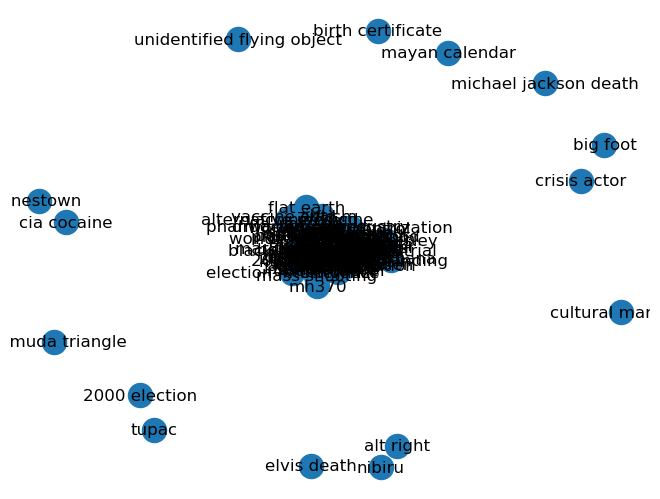

In [47]:
G = nx.DiGraph()
key_counts = dict(key_counts)

for k in key_counts.keys():
    G.add_node(k, label=k, size=key_counts[k])

for row in rule_list.values.tolist():
    G.add_edge(row[0], row[1], weight=row[2])


# pos = nx.spring_layout(G, seed=7)

# nx.draw_networkx_edges(G, pos, width=list(nx.get_edge_attributes(G, "weight").values()))

# # node labels
# nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

# nx.draw_networkx_nodes(G,pos,node_size=[key_counts[n] for n in G.nodes])
nx.draw(G, with_labels=True)

In [48]:
key_counts = dict(key_counts)
max_count = key_counts[max(key_counts, key= lambda x: key_counts[x])]

In [49]:
from d3graph import d3graph, vec2adjmat


source = rule_list['antecedents'].to_list()
target = rule_list['consequents'].to_list()
weights = rule_list['lift'].to_list()

adjmat = vec2adjmat(source, target, weight=weights)

# Initialize
d3 = d3graph(collision=3, charge=50000)
# Proces adjmat
d3.graph(adjmat)

# d3.set_node_properties(size=[key_counts[n] for n in adjmat.columns])
d3.set_node_properties(fontcolor='midnightblue', fontsize=16, edge_size=0)
for node in d3.node_properties.keys():
    d3.node_properties[node]['size'] = (key_counts[node.replace('_', ' ')] / max_count) * 50
    d3.node_properties[node]['label'] = node.replace('_', ' ')
    d3.node_properties[node]['color'] = 'green'

d3.set_edge_properties(edge_distance=100, directed=True)

[d3graph] INFO> Set directed=True to see the markers!
[d3graph] INFO> Keep only edges with weight>0
[d3graph] INFO> Number of unique nodes: 99
[d3graph] INFO> Number of unique nodes: 99
[d3graph] INFO> Keep only edges with weight>0


[colourmap]> Warning: Colormap [Set1] can not create [12] unique colors! Available unique colors: [9].


In [50]:
d3.show(filepath='./conspiracy.html')

[d3graph] INFO> Slider range is set to [0, 10]
[d3graph] INFO> Write to path: [/home/ldtcoop/projects/conspiracy-network/conspiracy.html]
[d3graph] INFO> File already exists and will be overwritten: [/home/ldtcoop/projects/conspiracy-network/conspiracy.html]
